# Sentiment Analyzer using machine learning models

#### Data-set: Amazon Alexa Reviews


In [1]:
#!pip install nltk
#nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')


# Import the required libraires
import numpy as np
import pandas as pd

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import re

# Pre-processing library
import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer


# Models library
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

df = pd.read_csv("/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv",sep="\t")
print(df.shape)
df.head()

/kaggle/input/amazon-alexa-reviews/amazon_alexa.tsv
(3150, 5)


,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


### Check the data we are dealing with as well as some visualization

          feedback
count  3150.000000
mean      0.918413
std       0.273778
min       0.000000
25%       1.000000
50%       1.000000
75%       1.000000
max       1.000000


array([[<AxesSubplot:title={'center':'feedback'}>]], dtype=object)

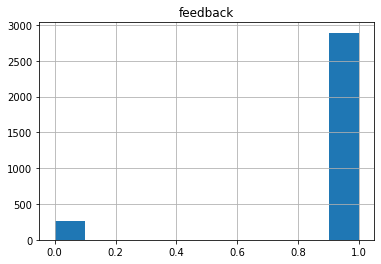

In [2]:
# Drop unrelated columns
df = df.drop(['date','variation','rating'],axis=1)
print(df.describe())
df.hist()

In [3]:
# Check for null values
df.isnull().sum()

verified_reviews    0
feedback            0
dtype: int64

### Clean and vectorize the *review* column so we can start working on it 

In [4]:
def clean_rev(review):
    stopwords = set(nltk.corpus.stopwords.words('english'))
    stopwords.remove('not')
    stopwords.remove('nor')
    review = review.lower()
    review = re.sub("[^A-Za-z0-9]",' ',review)
    review = re.sub(r'[0-9]+',' ',review)
    review = " ".join(PorterStemmer().stem(i) for i in review.split() if i not in stopwords)
    
    return review

df['verified_reviews'] = df['verified_reviews'].apply(lambda rev: clean_rev(rev))

### Create Vectorizer and TF-IDF

In [5]:
vectorizer = CountVectorizer(max_features=5000)
vectorizer.fit_transform(df['verified_reviews'])

x_vectorized = vectorizer.transform(df['verified_reviews'])


tfidfer = TfidfTransformer()
tfidfer.fit_transform(x_vectorized)
x = tfidfer.transform(x_vectorized)

### Create training sets

In [6]:
y = df['feedback']
x_train, x_test ,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=42)

# Oversampling
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
oversample = RandomOverSampler(sampling_strategy='minority')
# fit and apply the transform
print(y_train.value_counts())
x_train_oversampled, y_train_oversampled = oversample.fit_resample(x_train, y_train)
print(y_train_oversampled.value_counts())

# Undersampling
from imblearn.under_sampling import RandomUnderSampler
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority')
# fit and apply the transform
x_train_undersampled, y_train_undersampled = undersample.fit_resample(x_train, y_train)
print(y_train_undersampled.value_counts())

1    2321
0     199
Name: feedback, dtype: int64
1    2321
0    2321
Name: feedback, dtype: int64
0    199
1    199
Name: feedback, dtype: int64


### Start by using SVM and creating and training model

In [7]:
model_smv = svm.SVC()
model_smv.fit(x_train, y_train)
smv_pred = model_smv.predict(x_test)

In [8]:
# with cleass weight balanced
model_smv = svm.SVC(class_weight='balanced')
model_smv.fit(x_train, y_train)
smv_pred_balanced = model_smv.predict(x_test)

In [9]:
# Now repeat but with oversampling
model_smv = svm.SVC()
model_smv.fit(x_train_oversampled, y_train_oversampled)
smv_oversampled_pred = model_smv.predict(x_test)

In [10]:
# Now repeat but with undersampling
model_smv = svm.SVC()
model_smv.fit(x_train_undersampled, y_train_undersampled)
smv_undersampled_pred = model_smv.predict(x_test)

### Now the same for RandomForest model

In [11]:
model_RFC = RandomForestClassifier()
model_RFC.fit(x_train,y_train)
RFC_pred = model_RFC.predict(x_test)

In [12]:
# with class weight balanced
model_RFC = RandomForestClassifier(class_weight='balanced')
model_RFC.fit(x_train,y_train)
RFC_pred_balanced = model_RFC.predict(x_test)

In [13]:
# Now repeat but with oversampling
model_RFC = RandomForestClassifier()
model_RFC.fit(x_train_oversampled,y_train_oversampled)
RFC_oversampled_pred = model_RFC.predict(x_test)

In [14]:
# Now repeat but with undersampling
model_RFC = RandomForestClassifier()
model_RFC.fit(x_train_undersampled,y_train_undersampled)
RFC_undersampled_pred = model_RFC.predict(x_test)

### import metrics and see the performance of both models

In [15]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

print(f'SVM(normal):\nConfusion matrix: \n{confusion_matrix(y_test, smv_pred)}\n')
print(f'The F1 score is: {f1_score(y_test, smv_pred, average="macro")*100}')
print(f'The precision score is: {precision_score(y_test, smv_pred, average="macro")*(100)}')
print(f'The recall score is: {recall_score(y_test, smv_pred, average="macro")*100}') 
print(f'The accuracy score is: {accuracy_score(y_test, smv_pred)*100}\n\n\n')

print(f'SVM(balanced):\nConfusion matrix: \n{confusion_matrix(y_test, smv_pred_balanced)}\n')
print(f'The F1 score is: {f1_score(y_test, smv_pred_balanced, average="macro")*100}')
print(f'The precision score is: {precision_score(y_test, smv_pred_balanced, average="macro")*(100)}')
print(f'The recall score is: {recall_score(y_test, smv_pred_balanced, average="macro")*100}') 
print(f'The accuracy score is: {accuracy_score(y_test, smv_pred_balanced)*100}\n\n\n')

print(f'SVM(oversampled):\nConfusion matrix: \n{confusion_matrix(y_test, smv_oversampled_pred)}\n')
print(f'The F1 score is: {f1_score(y_test, smv_oversampled_pred, average="macro")*100}')
print(f'The precision score is: {precision_score(y_test, smv_oversampled_pred, average="macro")*(100)}')
print(f'The recall score is: {recall_score(y_test, smv_oversampled_pred, average="macro")*100}') 
print(f'The accuracy score is: {accuracy_score(y_test, smv_oversampled_pred)*100}\n\n\n')

print(f'SVM(undersampled):\nConfusion matrix: \n{confusion_matrix(y_test, smv_undersampled_pred)}\n')
print(f'The F1 score is: {f1_score(y_test, smv_undersampled_pred, average="macro")*100}')
print(f'The precision score is: {precision_score(y_test, smv_undersampled_pred, average="macro")*(100)}')
print(f'The recall score is: {recall_score(y_test, smv_undersampled_pred, average="macro")*100}') 
print(f'The accuracy score is: {accuracy_score(y_test, smv_undersampled_pred)*100}\n\n\n')



print(f'RandomForest(normal):\nConfusion matrix: \n{confusion_matrix(y_test, RFC_pred)}\n')
print(f'The F1 score is: {f1_score(y_test, RFC_pred, average="macro")*100}')
print(f'The precision score is: {precision_score(y_test, RFC_pred, average="macro")*(100)}')
print(f'The recall score is: {recall_score(y_test, RFC_pred, average="macro")*100}') 
print(f'The accuracy score is: {accuracy_score(y_test, RFC_pred)*100}\n\n\n')

print(f'RandomForest(balanced):\nConfusion matrix: \n{confusion_matrix(y_test, RFC_pred_balanced)}\n')
print(f'The F1 score is: {f1_score(y_test, RFC_pred_balanced, average="macro")*100}')
print(f'The precision score is: {precision_score(y_test, RFC_pred_balanced, average="macro")*(100)}')
print(f'The recall score is: {recall_score(y_test, RFC_pred_balanced, average="macro")*100}') 
print(f'The accuracy score is: {accuracy_score(y_test, RFC_pred_balanced)*100}\n\n\n')

print(f'RandomForest(oversampled):\nConfusion matrix: \n{confusion_matrix(y_test, RFC_oversampled_pred)}\n')
print(f'The F1 score is: {f1_score(y_test, RFC_oversampled_pred, average="macro")*100}')
print(f'The precision score is: {precision_score(y_test, RFC_oversampled_pred, average="macro")*(100)}')
print(f'The recall score is: {recall_score(y_test, RFC_oversampled_pred, average="macro")*100}') 
print(f'The accuracy score is: {accuracy_score(y_test, RFC_oversampled_pred)*100}\n\n\n')

print(f'RandomForest(undersampled):\nConfusion matrix: \n{confusion_matrix(y_test, RFC_undersampled_pred)}\n')
print(f'The F1 score is: {f1_score(y_test, RFC_undersampled_pred, average="macro")*100}')
print(f'The precision score is: {precision_score(y_test, RFC_undersampled_pred, average="macro")*(100)}')
print(f'The recall score is: {recall_score(y_test, RFC_undersampled_pred, average="macro")*100}') 
print(f'The accuracy score is: {accuracy_score(y_test, RFC_undersampled_pred)*100}\n\n\n')

SVM(normal):
Confusion matrix: 
[[ 14  44]
 [  0 572]]

The F1 score is: 67.5925925925926
The precision score is: 96.42857142857143
The recall score is: 62.06896551724138
The accuracy score is: 93.01587301587301



SVM(balanced):
Confusion matrix: 
[[ 29  29]
 [ 15 557]]

The F1 score is: 76.53154526059129
The precision score is: 80.48014272417004
The recall score is: 73.68881118881119
The accuracy score is: 93.01587301587301



SVM(oversampled):
Confusion matrix: 
[[ 29  29]
 [ 15 557]]

The F1 score is: 76.53154526059129
The precision score is: 80.48014272417004
The recall score is: 73.68881118881119
The accuracy score is: 93.01587301587301



SVM(undersampled):
Confusion matrix: 
[[ 53   5]
 [113 459]]

The F1 score is: 67.96573359073359
The precision score is: 65.42506231823847
The recall score is: 85.81203279479142
The accuracy score is: 81.26984126984127



RandomForest(normal):
Confusion matrix: 
[[ 22  36]
 [  4 568]]

The F1 score is: 74.48979591836735
The precision score is: 

In [16]:
import pickle
